In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd

In [2]:
MEASUREMENTS = ['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc', 'average_precision',
               'collecting_datasets', 'training', 'training_per_epoch', 'prediction']

MEASUREMENTS_AGGREGATION = { m: ['mean', 'std'] for m in MEASUREMENTS }

MEASUREMENT_NAMES = { m: m.capitalize().replace('_', ' ') for m in MEASUREMENTS }
for m in ['collecting_datasets', 'training', 'training_per_epoch', 'prediction']:
    MEASUREMENT_NAMES[m] += ' time [s]'

In [3]:
def aggregate_results(results, experiment_type):
    if not 'output_label' in results.columns:
        results['output_label'] = 1
    results_filtered = results[results['experiment_type'] == experiment_type]
    experiment_type = experiment_type.replace(' ', '_')
    return results_filtered.groupby([experiment_type, 'output_label']).agg(MEASUREMENTS_AGGREGATION)

In [4]:
# we decrease the number of plots in case of multilabel classification to make it more readable,
OUTPUT_LABEL_START = 1
OUTPUT_LABEL_END = 5

def plot(grouped_results, xlabel):
    fig, axes = plt.subplots(nrows=len(MEASUREMENTS) // 2, ncols=2, figsize=(15, 3.5 * len(MEASUREMENTS)))
    for i, m in enumerate(MEASUREMENTS):
        ax = axes[i // 2][i % 2]
        for output_label in range(OUTPUT_LABEL_START, OUTPUT_LABEL_END + 1):
            if i >= 6 and output_label > 1:
                # only one plot for time data
                continue
            if output_label in grouped_results.index.get_level_values(1):
                df = grouped_results.xs(output_label, level=1)
                ax.errorbar(
                    df.index,
                    df[m]['mean'], df[m]['std'],
                    linestyle='None', marker='x', uplims=True, lolims=True
                )
        ax.set_xscale('log')
        xticks = grouped_results.index.get_level_values(0).unique().sort_values()
        ax.set_xticks(xticks)
        ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
        ax.set_xlabel(xlabel, size=14)
        ax.set_ylabel(MEASUREMENT_NAMES[m], size=14)
        ax.set_title(f'{xlabel} vs. {MEASUREMENT_NAMES[m]}', size=17)
        ax.grid(True)
    plt.show()

### Mortality

In [5]:
mortality_results = pd.read_csv('results/mortality_binary_classification.csv')

In [6]:
mortality_results

,experiment_type,train_size,num_of_workers,accuracy,precision,recall,f1_score,roc_auc,average_precision,collecting_datasets,training,training_per_epoch,prediction
0,train size,50.0,3,0.844557,0.263780,0.268717,0.266225,0.668863,0.235348,0.008256,6.395798,0.177661,6.864800
1,train size,50.0,3,0.867845,0.289130,0.177807,0.220199,0.649171,0.210330,0.008318,6.863202,0.159609,6.822238
2,train size,50.0,3,0.895062,0.000000,0.000000,0.000000,0.594525,0.175119,0.008331,3.356932,0.159854,6.879266
3,train size,50.0,3,0.853795,0.309677,0.321285,0.315375,0.695017,0.274136,0.008504,27.215147,0.159153,6.826596
4,train size,50.0,3,0.895173,0.000000,0.000000,0.000000,0.574698,0.175087,0.008432,3.384312,0.161158,6.814792
...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,num of workers,NaN,128,0.903479,0.631579,0.192513,0.295082,0.843949,0.447426,0.641160,885.850644,26.843959,9.765104
66,num of workers,NaN,128,0.903058,0.615385,0.203209,0.305528,0.838457,0.431690,0.637118,859.582958,26.861967,9.847033
67,num of workers,NaN,128,0.903339,0.590214,0.258021,0.359070,0.857980,0.468422,0.641292,1396.071816,26.847535,9.994235
68,num of workers,NaN,128,0.905711,0.677725,0.191432,0.298539,0.845900,0.455985,0.645691,939.973848,26.856396,9.286214


In [7]:
grouped_mortality_train_size = aggregate_results(mortality_results, 'train size')
grouped_mortality_train_size

accuracy           precision              recall  \
                             mean       std      mean       std      mean   
train_size output_label                                                     
50.0       1             0.871286  0.023281  0.172517  0.158323  0.153562   
100.0      1             0.895783  0.001874  0.165730  0.254953  0.028112   
500.0      1             0.894772  0.003535  0.506396  0.088421  0.073821   
1000.0     1             0.895979  0.002078  0.578088  0.070067  0.081821   
5000.0     1             0.902405  0.002120  0.597751  0.039922  0.220697   
10000.0    1             0.903275  0.001992  0.628456  0.040408  0.194219   

                                   f1_score             roc_auc            \
                              std      mean       std      mean       std   
train_size output_label                                                     
50.0       1             0.149283  0.160360  0.150207  0.636455  0.050531   
100.0      1             0.061376  0.045599  0.099031  0.692697  0.048257   
500.0      1             0.045158  0.124119  0.066880  0.704440  0.035047   
1000.0     1             0.075944  0.129694  0.114646  0.753855  0.012370   
5000.0     1             0.020021  0.321280  0.016919  0.821088  0.010922   
10000.0    1             0.013686  0.296169  0.014874  0.832807  0.005578   

                        average_precision           collecting_datasets  \
                                     mean       std                mean   
train_size output_label                                                   
50.0       1                     0.214004  0.042165            0.008368   
100.0      1                     0.254059  0.055210            0.008320   
500.0      1                     0.260126  0.037059            0.008241   
1000.0     1                     0.333922  0.018334            0.008434   
5000.0     1                     0.422567  0.009970            0.008298   
10000.0    1                     0.437308  0.014329            0.008555   

                                     training            training_per_epoch  \
                              std        mean        std               mean   
train_size output_label                                                       
50.0       1             0.000099    9.443078  10.068986           0.163487   
100.0      1             0.000122    5.549138   1.787458           0.180284   
500.0      1             0.000061   16.153625   3.187924           0.438811   
1000.0     1             0.000242   43.988002  20.233890           0.743658   
5000.0     1             0.000062  274.131447  51.456880           3.540162   
10000.0    1             0.000277  588.138484  88.225909           7.018888   

                                  prediction            
                              std       mean       std  
train_size output_label                                 
50.0       1             0.007958   6.841538  0.028617  
100.0      1             0.001332   6.863178  0.033307  
500.0      1             0.004274   6.708847  0.080304  
1000.0     1             0.002666   6.800266  0.045685  
5000.0     1             0.011825   6.817570  0.128595  
10000.0    1             0.018665   7.056671  0.192704

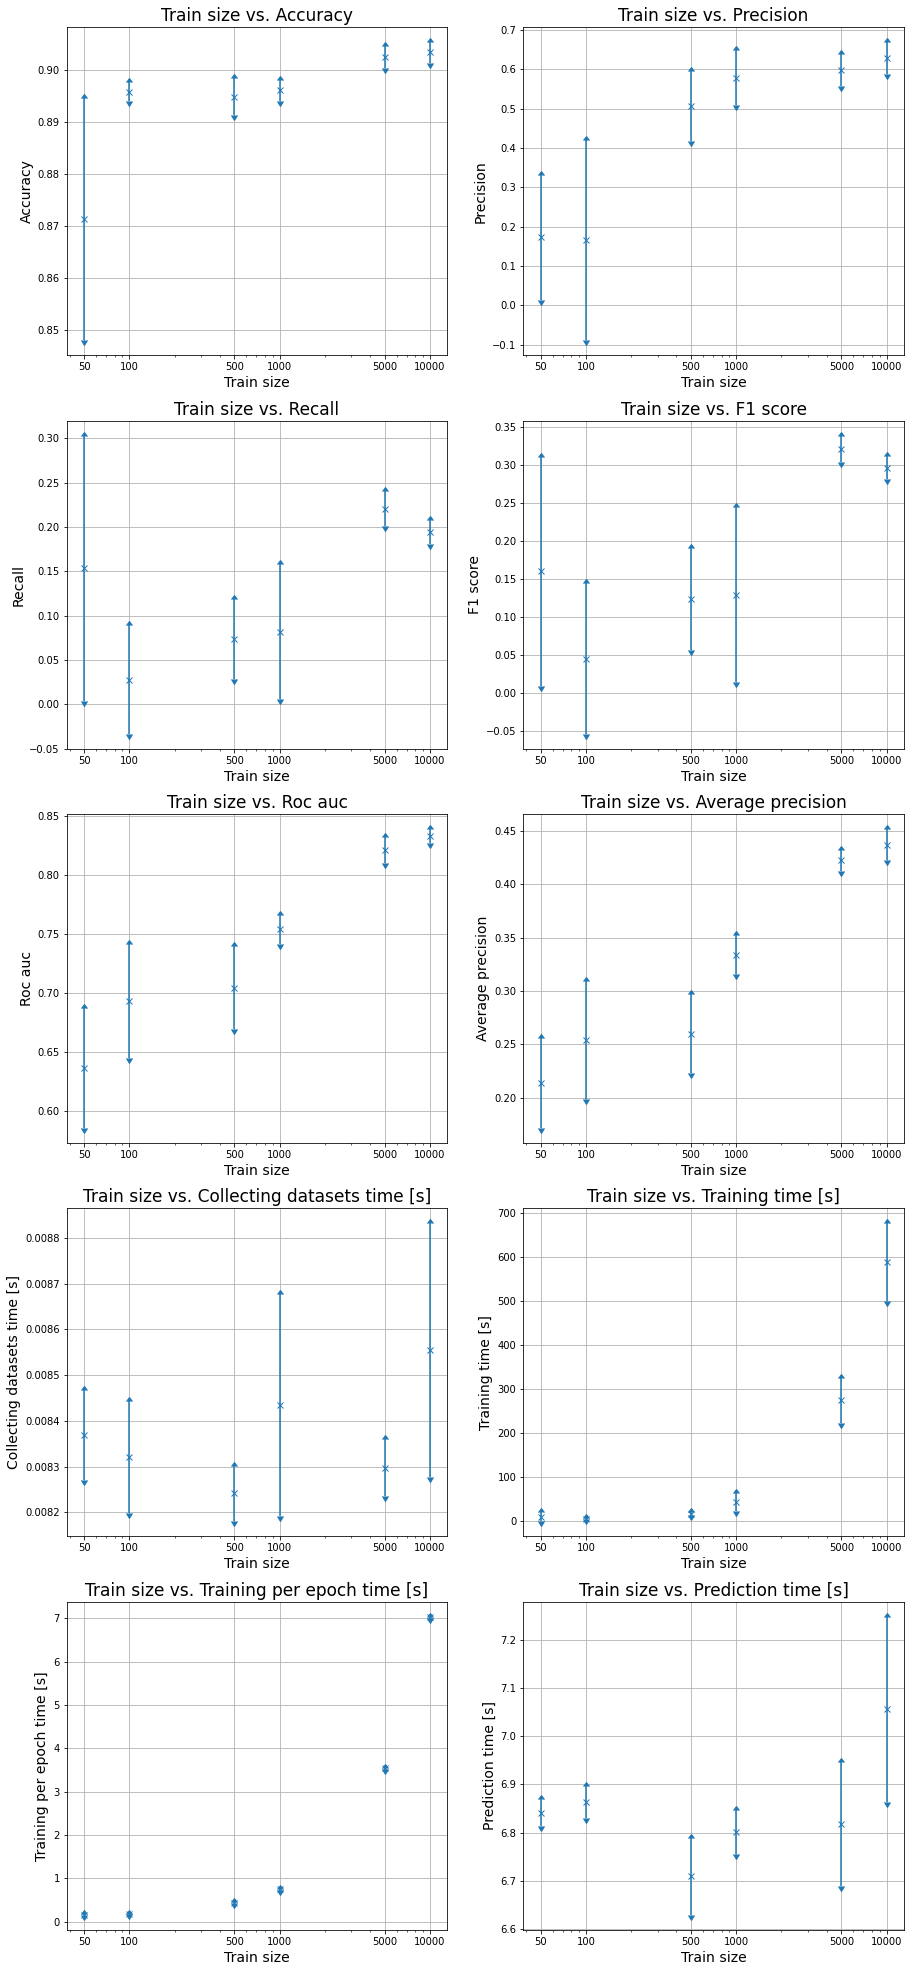

In [8]:
plot(grouped_mortality_train_size, 'Train size')

In [9]:
grouped_mortality_workers = aggregate_results(mortality_results, 'num of workers')
grouped_mortality_workers

accuracy           precision              recall  \
                                 mean       std      mean       std      mean   
num_of_workers output_label                                                     
1              1             0.906446  0.001889  0.647370  0.031961  0.240236   
2              1             0.905688  0.001890  0.634346  0.035334  0.242907   
4              1             0.905492  0.001457  0.633800  0.034573  0.240228   
8              1             0.905548  0.001311  0.630685  0.021746  0.241572   
16             1             0.906193  0.001360  0.660289  0.036173  0.222840   
32             1             0.905379  0.001838  0.637231  0.038461  0.233007   
64             1             0.905688  0.001198  0.644877  0.016236  0.224986   
128            1             0.903948  0.001064  0.637023  0.036902  0.202770   

                                       f1_score             roc_auc            \
                                  std      mean       std      mean       std   
num_of_workers output_label                                                     
1              1             0.018067  0.349784  0.017164  0.852484  0.004878   
2              1             0.023048  0.350238  0.020039  0.853090  0.005667   
4              1             0.028817  0.346896  0.025267  0.853225  0.004927   
8              1             0.012254  0.349045  0.011783  0.852953  0.005222   
16             1             0.028878  0.331630  0.026894  0.852065  0.006033   
32             1             0.022153  0.340073  0.019236  0.851844  0.007152   
64             1             0.017640  0.333222  0.019245  0.845967  0.008716   
128            1             0.033351  0.305547  0.032869  0.847218  0.007275   

                            average_precision           collecting_datasets  \
                                         mean       std                mean   
num_of_workers output_label                                                   
1              1                     0.469128  0.009324            0.003280   
2              1                     0.470601  0.012030            0.006051   
4              1                     0.468754  0.010782            0.011126   
8              1                     0.470044  0.009745            0.022801   
16             1                     0.468741  0.010376            0.046423   
32             1                     0.466997  0.012225            0.101691   
64             1                     0.459220  0.013869            0.245394   
128            1                     0.454057  0.015131            0.639437   

                                          training              \
                                  std         mean         std   
num_of_workers output_label                                      
1              1             0.000154  1423.962022  158.023648   
2              1             0.000302  1456.008804  214.721726   
4              1             0.000286  1431.775481  144.447996   
8              1             0.000608  1383.396039  113.655671   
16             1             0.001825  1184.169107  113.568254   
32             1             0.000474  1063.760777  197.238724   
64             1             0.002262  1117.065253  257.427357   
128            1             0.005180  1020.978566  218.843973   

                            training_per_epoch           prediction            
                                          mean       std       mean       std  
num_of_workers output_label                                                    
1              1                     19.992243  0.085316   7.381367  0.436188  
2              1                     20.267370  0.099509   7.618592  0.154550  
4              1                     20.389924  0.102932   7.322843  0.517240  
8              1                     20.470017  0.092388   7.242310  0.554256  
16             1                     20.917346  0.085293   7.094450  0.328773  
32      

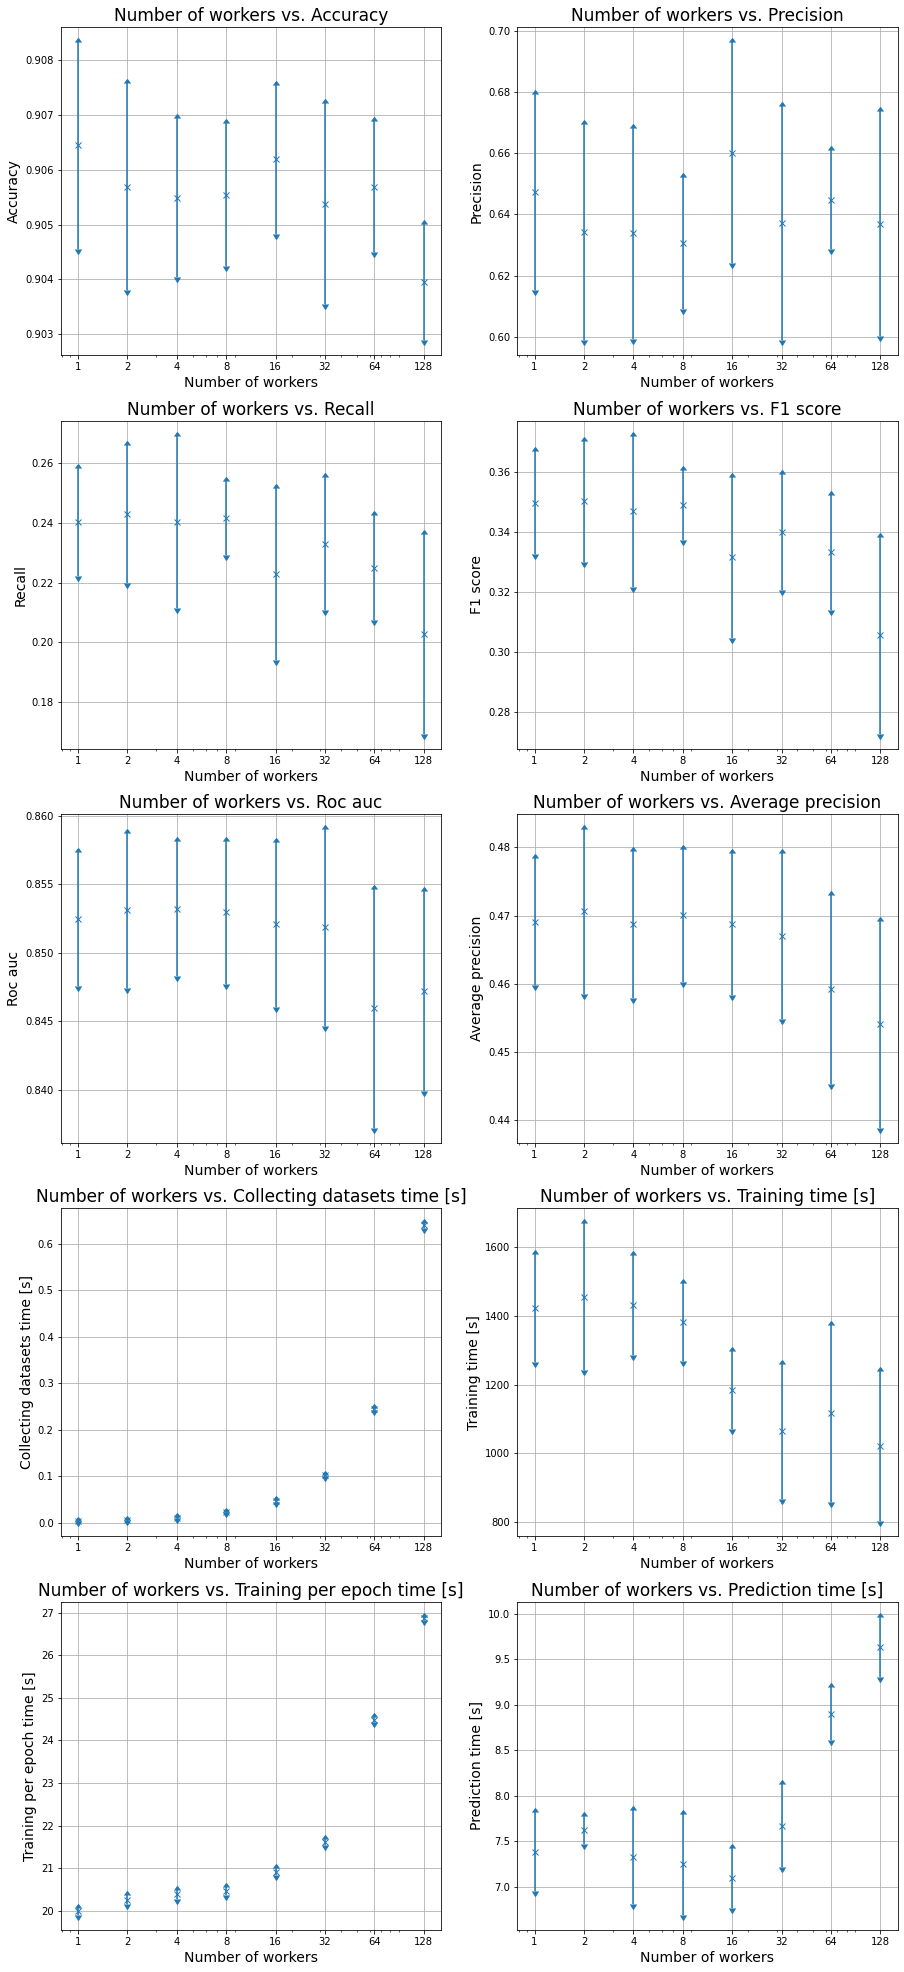

In [10]:
plot(grouped_mortality_workers, 'Number of workers')

### ICD-9

In [11]:
icd9_results = pd.read_csv('results/icd9_multilabel_classification.csv')

In [12]:
grouped_icd9_train_size = aggregate_results(icd9_results, 'train size')
grouped_icd9_train_size

accuracy           precision              recall  \
                             mean       std      mean       std      mean   
train_size output_label                                                     
50.0       1             0.739113  0.005734  0.195478  0.268322  0.051436   
           2             0.823064  0.002300  0.133333  0.298142  0.004358   
           3             0.670679  0.023036  0.712225  0.035749  0.891324   
           4             0.632183  0.003691  0.238433  0.331399  0.068548   
           5             0.657464  0.050455  0.243167  0.227761  0.075206   
...                           ...       ...       ...       ...       ...   
10000.0    16            0.916274  0.003511  0.000000  0.000000  0.000000   
           17            0.969501  0.001351  0.000000  0.000000  0.000000   
           18            0.627722  0.004828  0.610633  0.009142  0.461715   
           19            0.599355  0.009441  0.586597  0.008322  0.575098   
           20            0.692452  0.004805  0.609994  0.024603  0.189357   

                                   f1_score             roc_auc            \
                              std      mean       std      mean       std   
train_size output_label                                                     
50.0       1             0.083334  0.077454  0.119300  0.594953  0.047503   
           2             0.009745  0.008440  0.018873  0.652642  0.035010   
           3             0.148301  0.784255  0.041165  0.582123  0.109218   
           4             0.139056  0.088563  0.171162  0.603740  0.033297   
           5             0.146525  0.080701  0.141959  0.502144  0.036587   
...                           ...       ...       ...       ...       ...   
10000.0    16            0.000000  0.000000  0.000000  0.584007  0.017235   
           17            0.000000  0.000000  0.000000  0.670496  0.027676   
           18            0.019711  0.525537  0.010730  0.658691  0.002841   
           19            0.073242  0.578700  0.036457  0.642423  0.006389   
           20            0.030107  0.287500  0.032744  0.635833  0.004836   

                        average_precision           collecting_datasets  \
                                     mean       std                mean   
train_size output_label                                                   
50.0       1                     0.350070  0.038477            0.009909   
           2                     0.326816  0.065322            0.009909   
           3                     0.742544  0.075553            0.009909   
           4                     0.478775  0.029507            0.009909   
           5                     0.329062  0.026923            0.009909   
...                                   ...       ...                 ...   
10000.0    16                    0.111128  0.004730            0.010015   
           17                    0.057700  0.009386            0.010015   
           18                    0.621891  0.002511            0.010015   
           19                    0.598218  0.005447            0.010015   
           20                    0.496487  0.010517            0.010015   

                                     training            training_per_epoch  \
                              std        mean        std               mean   
train_size output_label                                                       
50.0       1             0.000094     7.68924   1.741724           0.215593   
           2             0.000094     7.68924   1.741724           0.215593   
           3             0.000094     7.68924   1.741724           0.215593   
           4             0.000094     7.68924   1.741724           0.215593   
           5             0.000094     7.68924   1.741724           0.215593   
...                           ...         ...        ...                ...   
10000.0    16            0.000339  1028.91498  96.600078           8.977784   
           17            0

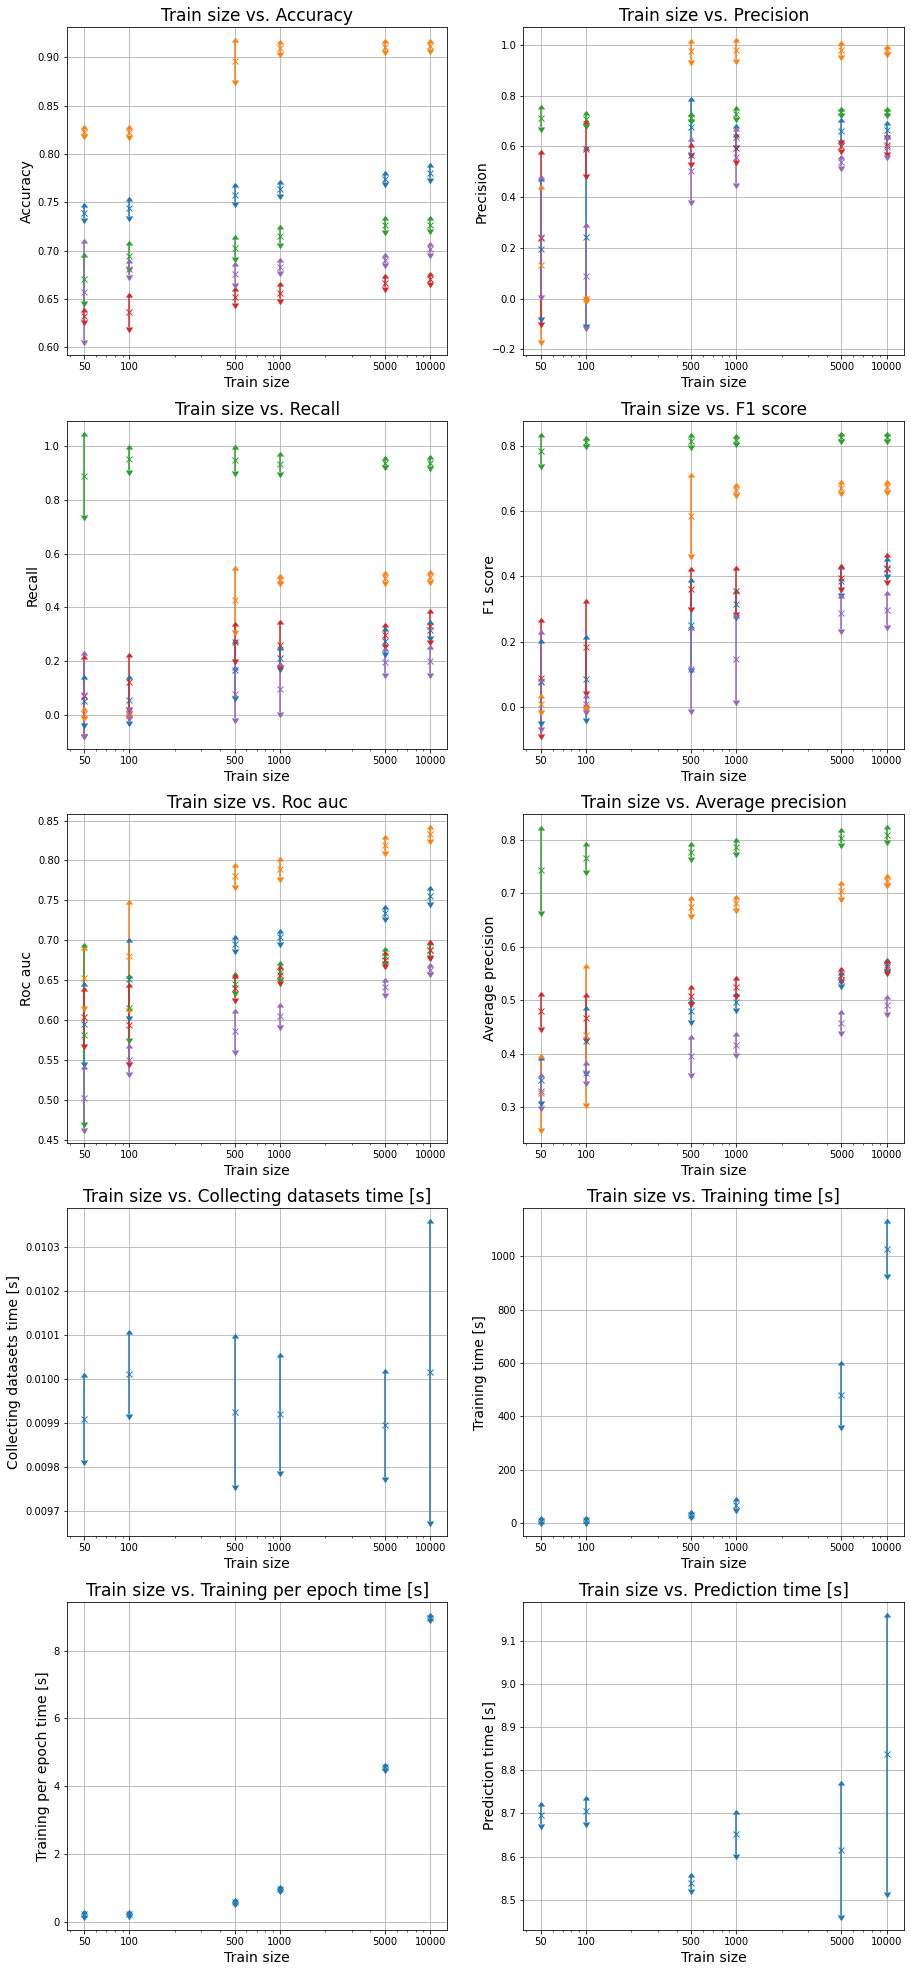

In [13]:
plot(grouped_icd9_train_size, 'Train size')

In [14]:
grouped_icd9_workers = aggregate_results(icd9_results, 'num of workers')
grouped_icd9_workers

accuracy           precision              recall  \
                                 mean       std      mean       std      mean   
num_of_workers output_label                                                     
1              1             0.782716  0.003229  0.673821  0.020775  0.316575   
               2             0.912402  0.002994  0.980562  0.007307  0.516364   
               3             0.730219  0.005940  0.737129  0.006775  0.944028   
               4             0.675561  0.003550  0.606835  0.021233  0.357285   
               5             0.706734  0.005477  0.609300  0.016454  0.220983   
...                               ...       ...       ...       ...       ...   
128            16            0.916274  0.003511  0.000000  0.000000  0.000000   
               17            0.969501  0.001351  0.000000  0.000000  0.000000   
               18            0.634989  0.005582  0.637245  0.017600  0.428156   
               19            0.605892  0.006464  0.592096  0.007713  0.588593   
               20            0.700309  0.003835  0.676290  0.008302  0.173536   

                                       f1_score             roc_auc            \
                                  std      mean       std      mean       std   
num_of_workers output_label                                                     
1              1             0.014932  0.430343  0.010388  0.769826  0.006451   
               2             0.007863  0.676463  0.007516  0.849647  0.005091   
               3             0.008496  0.827812  0.004504  0.697838  0.005845   
               4             0.034842  0.448340  0.022034  0.701625  0.008450   
               5             0.018471  0.323974  0.020932  0.678409  0.003280   
...                               ...       ...       ...       ...       ...   
128            16            0.000000  0.000000  0.000000  0.572996  0.010720   
               17            0.000000  0.000000  0.000000  0.653543  0.010055   
               18            0.034556  0.511147  0.021071  0.670133  0.005063   
               19            0.034016  0.589850  0.015703  0.648798  0.007179   
               20            0.014058  0.275997  0.018248  0.649472  0.002550   

                            average_precision           collecting_datasets  \
                                         mean       std                mean   
num_of_workers output_label                                                   
1              1                     0.582442  0.005869            0.004352   
               2                     0.745639  0.005851            0.004352   
               3                     0.817703  0.006294            0.004352   
               4                     0.579151  0.008435            0.004352   
               5                     0.512603  0.011868            0.004352   
...                                       ...       ...                 ...   
128            16                    0.105548  0.005876            0.882713   
               17                    0.054557  0.004227            0.882713   
               18                    0.634360  0.004588            0.882713   
               19                    0.602772  0.007299            0.882713   
               20                    0.513645  0.009039            0.882713   

                                          training              \
                                  std         mean         std   
num_of_workers output_label                                      
1              1             0.000120  2599.782615  112.062922   
               2             0.000120  2599.782615  112.062922   
               3             0.000120  2599.782615  112.062922   
               4             0.000120  2599.782615  112.062922   
               5             0.000120  2599.782615  112.062922   
...                               ...          ...         ...   
128            16            0.006113  1866.143338  310.05

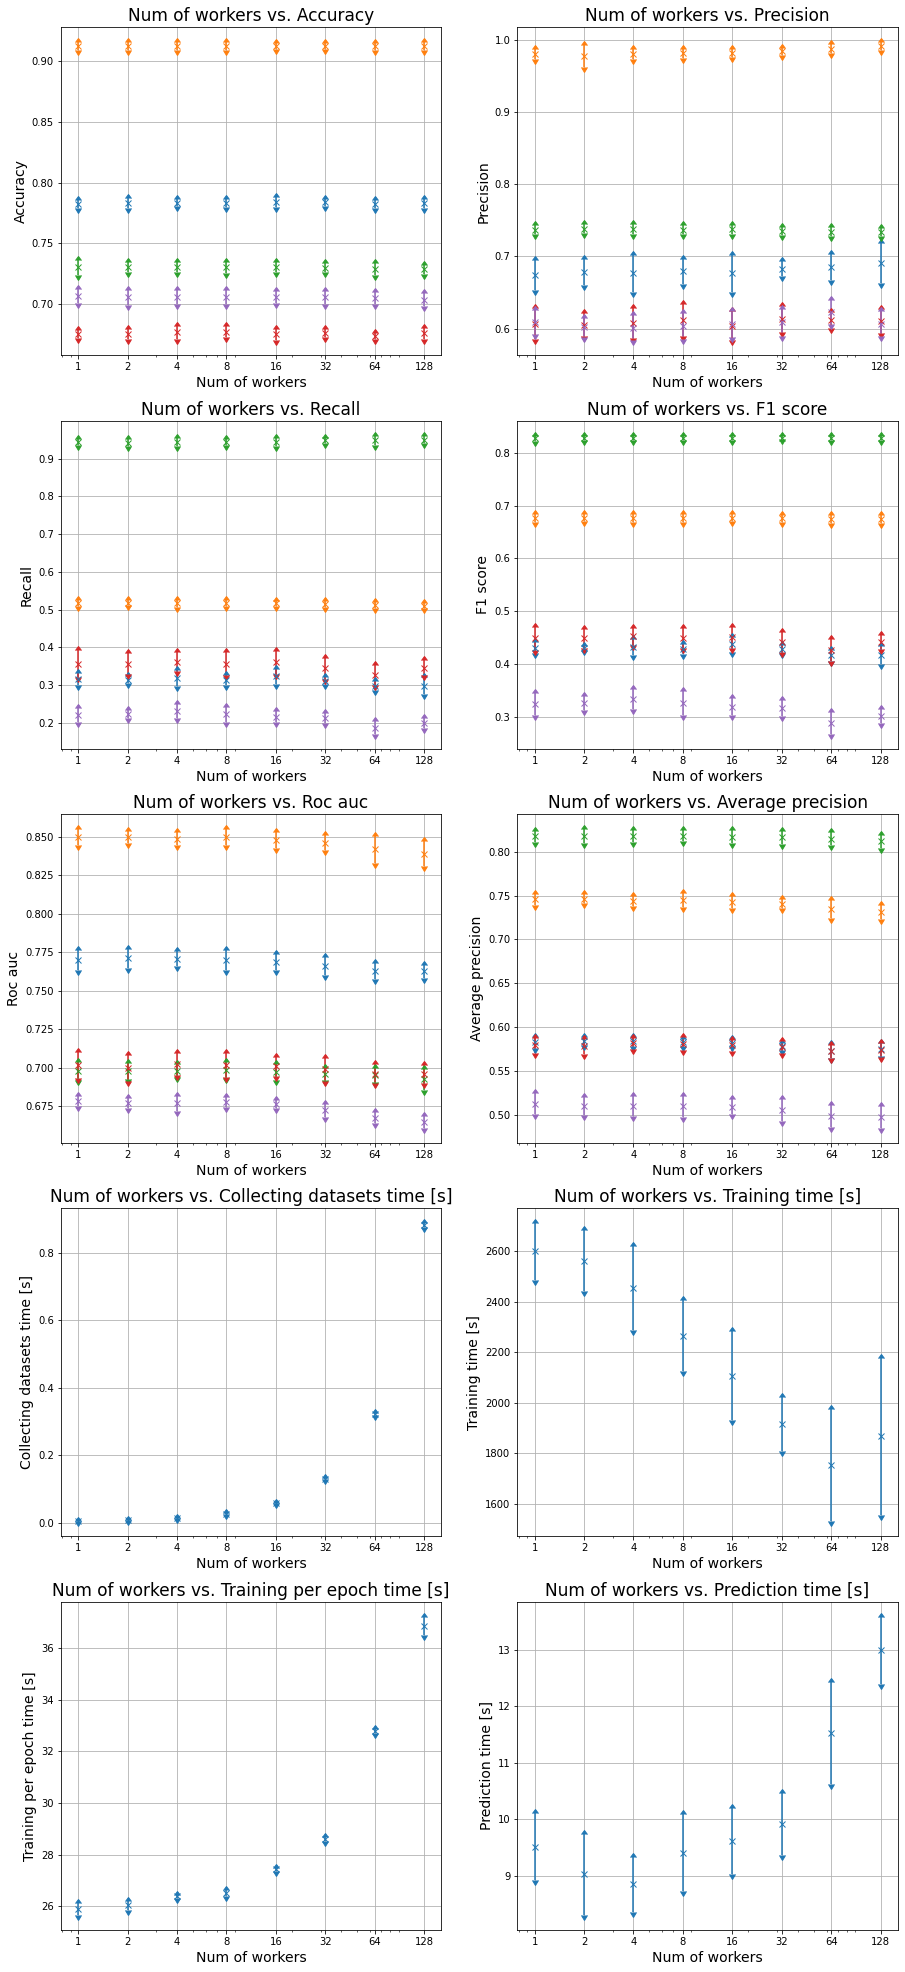

In [15]:
plot(grouped_icd9_workers, 'Num of workers')